# Community Finding - Algorithm Comparision
## Jake Carlson

## Load Data

In [1]:
import numpy as np
import pandas as pd
import igraph
import uuid
import matplotlib.pyplot as plt

df_q = pd.read_csv("./data/2008-questions.csv")
df_a = pd.read_csv("./data/2008-answers.csv")
df_t = pd.read_csv("./data/2008-tags.csv")

# remove NaN owner ids
df_q = df_q[np.isfinite(df_q.OwnerUserId.values)]
df_a = df_a[np.isfinite(df_a.OwnerUserId.values) & df_a.ParentId.isin(df_q.Id)]

df_q.OwnerUserId = df_q.OwnerUserId.astype(np.int)
df_a.OwnerUserId = df_a.OwnerUserId.astype(np.int)

df_q['qid'] = [str(uuid.uuid4()) for _ in range(len(df_q))]
df_a['qid'] = [df_q['qid'].values[df_q.Id == a][0] for a in df_a.ParentId.values]

In [2]:
owner_to_uid = {}
def get_uids(df):
    uids = []
    for i, r in df.iterrows():
        owner = r['OwnerUserId']
        uid = None
        if owner in owner_to_uid.keys():
            uid = owner_to_uid[owner]
        else:
            uid = str(uuid.uuid4())
            owner_to_uid[owner] = uid
        uids.append(uid)
    return uids

df_q['uid'] = get_uids(df_q)
df_a['uid'] = get_uids(df_a)

In [3]:
df_q.head()

,Id,OwnerUserId,CreationDate,Score,Title,qid,uid
0,80,26,2008-08-01T13:57:07Z,26,SQLStatement.execute() - multiple queries in o...,db481d12-b8e3-41c8-bf5b-6dba0750fa8f,92a62a1e-0b2b-45aa-9cca-33fbcd477920
1,90,58,2008-08-01T14:41:24Z,144,Good branching and merging tutorials for Torto...,298829a5-6307-4855-9180-c2a37ff9202b,7e93da16-da67-484a-bea9-4951ad3d5678
2,120,83,2008-08-01T15:50:08Z,21,ASP.NET Site Maps,831dfc83-17e4-4f62-b38a-d2fd56715e3e,cff8195c-b641-48d9-a04d-5aeb6f291e99
3,180,2089740,2008-08-01T18:42:19Z,53,Function for creating color wheels,a1dc0666-d435-4e44-b5f8-9ea13d7840f6,f091baa0-f0e0-48a9-8b18-629e1245014f
4,260,91,2008-08-01T23:22:08Z,49,Adding scripting functionality to .NET applica...,200222c4-300a-45c5-b425-ef3c2445eb87,aae887c3-973c-4ad9-b83e-893588a8cf09


In [4]:
df_a.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,qid,uid
0,92,61,2008-08-01T14:45:37Z,90,13,298829a5-6307-4855-9180-c2a37ff9202b,a0c3be0e-d6cc-4477-a592-74adf321412f
1,124,26,2008-08-01T16:09:47Z,80,12,db481d12-b8e3-41c8-bf5b-6dba0750fa8f,92a62a1e-0b2b-45aa-9cca-33fbcd477920
2,199,50,2008-08-01T19:36:46Z,180,1,a1dc0666-d435-4e44-b5f8-9ea13d7840f6,b231a081-bb99-4c44-a791-534f5e840230
3,269,91,2008-08-01T23:49:57Z,260,4,200222c4-300a-45c5-b425-ef3c2445eb87,aae887c3-973c-4ad9-b83e-893588a8cf09
4,307,49,2008-08-02T01:49:46Z,260,28,200222c4-300a-45c5-b425-ef3c2445eb87,a97ee512-464e-49b7-8eab-3a3ab6e4444d


In [5]:
df_t.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [6]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16912 entries, 0 to 16911
Data columns (total 2 columns):
Id     16912 non-null int64
Tag    16912 non-null object
dtypes: int64(1), object(1)
memory usage: 264.3+ KB


In [7]:
df_q.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5299 entries, 0 to 5824
Data columns (total 7 columns):
Id              5299 non-null int64
OwnerUserId     5299 non-null int64
CreationDate    5299 non-null object
Score           5299 non-null int64
Title           5299 non-null object
qid             5299 non-null object
uid             5299 non-null object
dtypes: int64(3), object(4)
memory usage: 331.2+ KB


In [10]:
users_to_questions = {}
for g, data in df_q.groupby(['uid']):
    users_to_questions[g] = set(data.qid.values)
for g, data in df_a.groupby(['uid']):
    if g in users_to_questions.keys():
        users_to_questions[g].update(data.qid.values)
    else:
        users_to_questions[g] = set(data.qid.values)

In [11]:
users = list(users_to_questions.keys())
questions = list(set([j for i in users_to_questions.values() for j in list(i)]))

In [12]:
users_to_idx = {}
for k, v in users_to_questions.items():
    users_to_idx[k] = [questions.index(q) for q in list(v)]

In [13]:
types = [1 for u in users] + [0 for q in questions]
edges = []
offset = len(users)
for i, u in enumerate(users):
    for j in users_to_idx[u]:
        edges.append((i, offset + j))

In [14]:
graph = igraph.Graph.Bipartite(types, edges)
graph.vs['name'] = users + questions

In [8]:
def get_largest_component(g):
    comps = g.components()
    sizes = comps.sizes()
    idx_largest = sizes.index(max(sizes))
    return comps.subgraph(idx_largest)

In [17]:
largest = get_largest_component(graph)

## Walktrap

In [13]:
dendrogram = largest.community_walktrap()
dendrogram.optimal_count

74

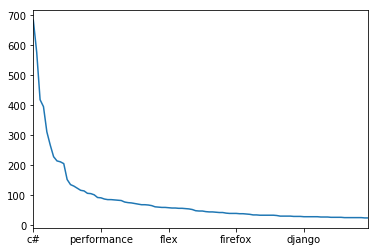

In [14]:
tag_counts = df_t.Tag.value_counts()
tag_counts[:100].plot()
plt.show()

In [29]:
clusters = dendrogram.as_clustering()
membership = clusters.membership
largest.vs['membership'] = membership

In [16]:
def get_n_tag_counts_for_membership(m, n):
    q_ids = set([graph.vs[i]['name'] for i in range(len(largest.vs)) if membership[i] == m])
    q_tags = df_t.Tag[df_t.Id.isin(df_q.Id[df_q.qid.isin(q_ids)])]
    return len(q_ids), q_tags.value_counts()[:n]

In [17]:
for m in list(set(membership)):
    num, counts = get_n_tag_counts_for_membership(m, 5)
    print(m, ":", num)
    print(counts)

0 : 201
php            35
apache         18
performance    15
perl           13
javascript     13
Name: Tag, dtype: int64
1 : 766
python           53
java             46
php              35
svn              31
visual-studio    30
Name: Tag, dtype: int64
2 : 1133
c#               536
.net             526
asp.net          104
winforms          58
visual-studio     40
Name: Tag, dtype: int64
3 : 270
asp.net          256
c#                42
javascript        19
asp.net-mvc       12
visual-studio     11
Name: Tag, dtype: int64
4 : 21
image         3
import        2
css           2
html          2
javascript    2
Name: Tag, dtype: int64
5 : 61
asp.net-mvc     59
c#               7
html-helper      3
unit-testing     3
routing          3
Name: Tag, dtype: int64
6 : 117
ruby-on-rails    12
sql-server       10
python            8
ruby              8
regex             7
Name: Tag, dtype: int64
7 : 388
c++        246
c           86
java        16
mfc         14
windows     13
Name: Tag, dtype: i

In [18]:
def show_n_questions_for_membership(m, n):
    q_ids = set([graph.vs[i]['name'] for i in range(len(largest.vs)) if membership[i] == m])
    q_titles = df_q.Title.values[df_q.qid.isin(q_ids)]
    return q_titles[:n]

In [19]:
show_n_questions_for_membership(2, 10)

array(['Adding scripting functionality to .NET applications',
       'Homegrown consumption of web services',
       'Automatically update version number',
       'How do I connect to a database and loop over a recordset in C#?',
       'How do I delete a file which is locked by another process in C#?',
       'Is nAnt still supported and suitable for .net 3.5/VS2008?',
       '.NET Unit Testing packages?', 'Datatable vs Dataset',
       'Converting ARBG to RGB with alpha blending',
       'How do I Transform Sql Columns into Rows?'], dtype=object)

In [60]:
def plot_memberships(ms):
    palette = igraph.drawing.colors.ClusterColoringPalette(len(clusters))
    colors = palette.get_many(membership)
    largest.vs['color'] = colors
    layout = largest.layout_lgl()
    p = igraph.drawing.Plot(background='white')
    for m in ms:
        p.add(clusters.subgraph(m), opacity=0.6, layout=layout)
    return p

In [61]:
plot = plot_memberships([0,1])
plot.show()

In [ ]:
palette = igraph.drawing.colors.ClusterColoringPalette(len(clusters))
colors = palette.get_many(membership)

# set user colors (r, b, g, a)
# for i in range(len(users)):
#     colors[i] = (1.0, 1.0, 1.0, 1.0)
# for i in range(len(questions)):
#     colors[offset+i] = (1.0, 0.0, 0.0, 1.0)
largest.vs['color'] = colors
igraph.plot(largest, opacity=0.5)

## Spinglass

In [67]:
clustering = largest.community_spinglass()
membership = clustering.membership

In [68]:
for m in list(set(membership)):
    num, counts = get_n_tag_counts_for_membership(m, 5)
    print(m, ":", num)
    print(counts)

0 : 121
.net       19
c#         15
c++        10
asp.net     8
java        8
Name: Tag, dtype: int64
1 : 109
c#         10
java       10
php         9
asp.net     8
.net        7
Name: Tag, dtype: int64
2 : 152
c#            26
.net          19
java          15
asp.net       13
javascript    10
Name: Tag, dtype: int64
3 : 123
c#            14
javascript    10
c++            9
.net           9
java           8
Name: Tag, dtype: int64
4 : 444
c#         51
.net       50
java       33
asp.net    32
sql        30
Name: Tag, dtype: int64
5 : 525
c#            62
.net          56
asp.net       38
java          32
javascript    30
Name: Tag, dtype: int64
6 : 151
c#         18
asp.net    14
.net       12
c++        11
java       10
Name: Tag, dtype: int64
7 : 379
.net       36
c#         29
java       27
asp.net    25
c++        20
Name: Tag, dtype: int64
8 : 106
c#               14
.net             10
visual-studio     7
python            7
vb.net            6
Name: Tag, dtype: int64
9 : 381

In [ ]:
palette = igraph.drawing.colors.ClusterColoringPalette(len(set(membership)))
colors = palette.get_many(membership)

# set user colors (r, b, g, a)
# for i in range(len(users)):
#     colors[i] = (1.0, 1.0, 1.0, 1.0)
# for i in range(len(questions)):
#     colors[offset+i] = (1.0, 0.0, 0.0, 1.0)
largest.vs['color'] = colors
igraph.plot(largest, opacity=0.5)

## Questions Only

In [9]:
tags_to_questions = {}
for g, data in df_t.groupby(['Tag']):
    tags_to_questions[g] = set(df_q.qid[df_q.Id.isin(data.Id)].values)

questions_to_questions = {}
for t, quids in tags_to_questions.items():
    for i, q in enumerate(quids):
        if q in questions_to_questions.keys():
            questions_to_questions[q].update(quids)
        else:
            questions_to_questions[q] = set(quids)
        questions_to_questions[q].remove(q)

questions = list(questions_to_questions.keys())
questions_to_idx = {}
for i, q in enumerate(questions):
    questions_to_idx[q] = i

In [10]:
edges = []
for k, v in questions_to_questions.items():
    for q in v:
        edges.append((questions_to_idx[k], questions_to_idx[q]))

In [11]:
graph = igraph.Graph(edges=edges)
graph.vs['name'] = questions

In [12]:
largest = get_largest_component(graph)